The German Credit data set is a publically available data set downloaded from the UCI Machine Learning Repository. The data contains data on 20 variables and the classification whether an applicant is considered a Good or a Bad credit risk for 1000 loan applicants.

### [Data Source](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))
- Professor Dr. Hans Hofmann  
- Institut f"ur Statistik und "Okonometrie  
- Universit"at Hamburg  
- FB Wirtschaftswissenschaften  
- Von-Melle-Park 5    
- 2000 Hamburg 13

### Benchmark
![Credit Risk Classification: Faster Machine Learning with Intel Optimized Packages](https://i.imgur.com/nL1l7WI.png)

according to [1] the best model is Random Forest with balanced feature selection data. it's has Accuracy 82%, Precision 84%, Recall 82% and F1-Score 81%. 

<br>


The goal of this kernel is to beat The benchmark with  :
- Convert dataset to Machine Learning friendly (Feature Engginering)
- Develop XGBoost model to predict whether a loan is a good or bad risk.
- Find the Best parameter for XGBoost Model (Hyperparameter Tunning)
- Beat the Benchmark

# Table of Content

**1. [Introduction](#Introduction)** <br>
    - Import Library
    - Evaluation Function
    - XGBoost Model
**2. [Preprocess](#Preprocess)** <br>
    - Importing Dataset
    - StandardScaler
    - Encoding Categorical Feature
    - Concate Transformed Dataset
    - Split Training Dataset
    - XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
    - XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)
**3. [Balanced Dataset](#Balanced Dataset)** <br>    
    - XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)
    - **XGBoost 2b: Balanced (ROC_AUC:0.80)**
**4. [Others](#Others)** <br>  
    - Lighgbm (ROC_AUC:0.73)
    - LogisticRegression (ROC_AUC:0.77)
    - RandomForestClassifier (ROC_AUC:0.69)
    - ExtraTreesClassifier (ROC_AUC:0.74)
    - DecisionTreeClassifier (ROC_AUC:0.64)
    - GradientBoostingClassifier (ROC_AUC:0.76)
    - AdaBoostClassifier (ROC_AUC:0.72)

<a id="Introduction"></a> <br>
# **1. Introduction:** 
- Import Library
- Evaluation Function
- XGBoost Model

### Import Library

In [1]:
#Importing necessary packages in Python 
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd

from sklearn.datasets import make_classification 
# from sklearn.learning_curve import learning_curve 
#from sklearn.cross_validation import train_test_split 
#from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

from pprint import pprint 
 


### Evaluation Function


In [2]:
# Function for evaluation reports
def get_eval1(clf, X,y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 

def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return  
  
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return


#### XGBoost Model

In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import xgboost as xgb
from xgboost import XGBClassifier
#print('XGBoost v',xgb.__version__)

# fit, train and cross validate Decision Tree with training and test data 
def xgbclf(params, X_train, y_train,X_test, y_test):
  
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    # model = XGBClassifier(**params).\
    #   fit(X_train, y_train, eval_set=eval_set, \
    #               eval_metric='auc', early_stopping_rounds = 100, verbose=100)
        
    # print(model.get_booster().best_ntree_limit)

    # model.set_params(**{'n_estimators': model.get_booster().best_ntree_limit})#model.best_ntree_limit})
    # model.fit(X_train, y_train)
    # #print(model,'\n')

    # # Predict target variables y for test data
    # y_pred = model.predict(X_test, ntree_limit=model.get_booster().best_ntree_limit) #model.best_iteration #model.best_ntree_limit
    # #print(y_pred)

    model = XGBClassifier(**params)
    model.fit(
        X_train, y_train, eval_set=[(X_test, y_test)],
        eval_metric='auc', early_stopping_rounds=100, verbose=True
    )

    # Checking if early stopping was used and setting iteration range accordingly
    if hasattr(model, 'best_iteration'):
        start_iteration = 0
        end_iteration = model.best_iteration + 1  # Ensure to include the best_iteration
        iteration_range = (start_iteration, end_iteration)
        y_pred = model.predict(X_test, iteration_range=iteration_range)
    else:
        y_pred = model.predict(X_test)
    
    
   
    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train)
    #get_eval2(model, X_train, y_train,X_test, y_test)
    
    # Create and print confusion matrix    
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    
    #y_pred = model.predict(X_test)
    print (classification_report(y_test,y_pred) )
    print ('\n')
    print ("Model Final Generalization Accuracy: %.6f" %accuracy_score(y_test,y_pred) )
    
    # Predict probabilities target variables y for test data
    y_pred_proba = model.predict_proba(X_test)[:,1] #model.best_iteration #best_ntree_limit #, ntree_limit=model.best_iteration)
    get_roc (y_test,y_pred_proba)
    return model

def plot_featureImportance(model, keys):
  importances = model.feature_importances_

  importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(keys)})
  importance_frame.sort_values(by = 'Importance', inplace = True)
  importance_frame.tail(10).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

<a id="Preprocess"></a> <br>
# **2. Preprocess** 
- Importing Dataset
- StandardScaler
- Encoding Categorical Feature
- Concate Transformed Dataset
- Split Training Dataset
- XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
- XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

### Import Dataset

OK let's get started. We'll download the data from the UCI website.

In [4]:
# file = '../input/germancreditdata/german.data'
# url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

# data = pd.read_csv(file,names = names, delimiter=' ')
# print(data.shape)
# print (data.columns)
# data.head(10)

In [5]:
# download the data from the official python library
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 


{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [6]:
X.head(2)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201


In [7]:
X.columns = names[:-1]

In [8]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
# data.classification.replace([1,2], [1,0], inplace=True)
y.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
# data.classification.value_counts()
y.value_counts()

/var/folders/p8/b11rskbj1zdf4sn__0fjfwdm0000gn/T/ipykernel_6706/1844793119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace([1,2], [1,0], inplace=True)


class
1        700
0        300
Name: count, dtype: int64

### StandardScaler

In [9]:
# #numerical variables labels
# numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
#            'existingcredits', 'peopleliable', 'classification']

# # Standardization
# numdata_std = pd.DataFrame(StandardScaler().fit_transform(X[numvars].drop(['classification'], axis=1)))

In [10]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable']#, 'classification']

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(X[numvars]))

### Encoding Categorical Feature

Labelencoding to transform categorical to numerical, Enables better Visualization than one hot encoding

In [11]:
# from collections import defaultdict

# #categorical variables labels
# catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
#            'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
#            'telephone', 'foreignworker']

# d = defaultdict(LabelEncoder)

# # Encoding the variable
# lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# # print transformations
# for x in range(len(catvars)):
#     print(catvars[x],": ", data[catvars[x]].unique())
#     print(catvars[x],": ", lecatdata[catvars[x]].unique())

# #One hot encoding, create dummy variables for every category of every categorical variable
# dummyvars = pd.get_dummies(data[catvars])

In [12]:
from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = X[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", X[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(X[catvars])

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


### Concate Transformed Dataset
append the dummy variable of the initial numerical variables numvars# append 

In [13]:
# data_clean = pd.concat([data[numvars], dummyvars], axis = 1)

# print(data_clean.shape)

In [14]:
data_clean = pd.concat([X[numvars], dummyvars], axis = 1)

print(data_clean.shape)

(1000, 61)


### Split Training Dataset

In [15]:
# # Unscaled, unnormalized data
# X_clean = data_clean.drop('classification', axis=1)
# y_clean = data_clean['classification']
# X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)

In [16]:
# Unscaled, unnormalized data
X_clean = data_clean
y_clean = y
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)

In [17]:
X_train_clean.keys()

Index(['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'existingchecking_A11',
       'existingchecking_A12', 'existingchecking_A13', 'existingchecking_A14',
       'credithistory_A30', 'credithistory_A31', 'credithistory_A32',
       'credithistory_A33', 'credithistory_A34', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64',
       'savings_A65', 'employmentsince_A71', 'employmentsince_A72',
       'employmentsince_A73', 'employmentsince_A74', 'employmentsince_A75',
       'statussex_A91', 'statussex_A92', 'statussex_A93', 'statussex_A94',
       'otherdebtors_A101', 'otherdebtors_A102', 'otherdebtors_A103',
       'property_A121', 'property_A122', 'property_A123', 'property_A124',
       'otherinstallmentplans_A141', 'otherinstallmentplans_A

### XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)

[0]	validation_0-auc:0.72419
[1]	validation_0-auc:0.74492
[2]	validation_0-auc:0.72605
[3]	validation_0-auc:0.74997
[4]	validation_0-auc:0.74119
[5]	validation_0-auc:0.74678
[6]	validation_0-auc:0.75322
[7]	validation_0-auc:0.74522
[8]	validation_0-auc:0.74558
[9]	validation_0-auc:0.74240
[10]	validation_0-auc:0.72677
[11]	validation_0-auc:0.72461
[12]	validation_0-auc:0.72665
[13]	validation_0-auc:0.72845
[14]	validation_0-auc:0.72485
[15]	validation_0-auc:0.72016
[16]	validation_0-auc:0.72052
[17]	validation_0-auc:0.72340
[18]	validation_0-auc:0.72148
[19]	validation_0-auc:0.72292
[20]	validation_0-auc:0.72052
[21]	validation_0-auc:0.72797
[22]	validation_0-auc:0.72893
[23]	validation_0-auc:0.72725
[24]	validation_0-auc:0.72076
[25]	validation_0-auc:0.71872
[26]	validation_0-auc:0.72112
[27]	validation_0-auc:0.72028
[28]	validation_0-auc:0.72389
[29]	validation_0-auc:0.72244
[30]	validation_0-auc:0.71836
[31]	validation_0-auc:0.72124
[32]	validation_0-auc:0.72449
[33]	validation_0-au

/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[78]	validation_0-auc:0.73326
[79]	validation_0-auc:0.73482
[80]	validation_0-auc:0.73494
[81]	validation_0-auc:0.73410
[82]	validation_0-auc:0.73254
[83]	validation_0-auc:0.73422
[84]	validation_0-auc:0.73555
[85]	validation_0-auc:0.73603
[86]	validation_0-auc:0.73615
[87]	validation_0-auc:0.73542
[88]	validation_0-auc:0.73567
[89]	validation_0-auc:0.73627
[90]	validation_0-auc:0.73591
[91]	validation_0-auc:0.73639
[92]	validation_0-auc:0.73795
[93]	validation_0-auc:0.73951
[94]	validation_0-auc:0.73771
[95]	validation_0-auc:0.73879
[96]	validation_0-auc:0.73699
[97]	validation_0-auc:0.73627
[98]	validation_0-auc:0.73567
[99]	validation_0-auc:0.73398
[[ 25  34]
 [ 18 123]]
              precision    recall  f1-score   support

           0       0.58      0.42      0.49        59
           1       0.78      0.87      0.83       141

    accuracy                           0.74       200
   macro avg       0.68      0.65      0.66       200
weighted avg       0.72      0.74      0.73  

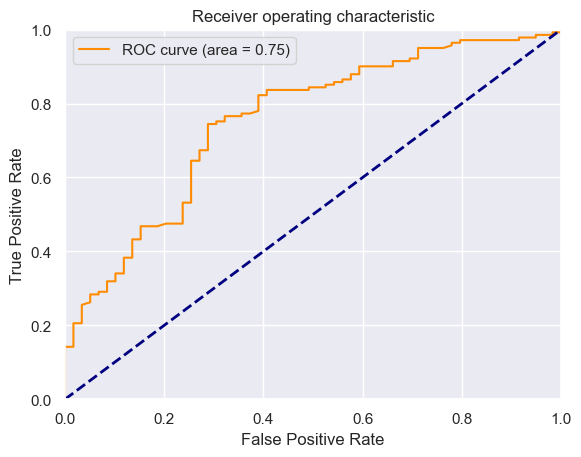

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
params={}
xgbclf(params, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

### XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

[0]	validation_0-auc:0.63842
[1]	validation_0-auc:0.69155
[2]	validation_0-auc:0.72184
[3]	validation_0-auc:0.75292
[4]	validation_0-auc:0.74612
[5]	validation_0-auc:0.76451
[6]	validation_0-auc:0.75346
[7]	validation_0-auc:0.76139
[8]	validation_0-auc:0.75826
[9]	validation_0-auc:0.76301
[10]	validation_0-auc:0.76277
[11]	validation_0-auc:0.76205
[12]	validation_0-auc:0.76710
[13]	validation_0-auc:0.76506
[14]	validation_0-auc:0.76986
[15]	validation_0-auc:0.76914
[16]	validation_0-auc:0.76776
[17]	validation_0-auc:0.77245
[18]	validation_0-auc:0.77041
[19]	validation_0-auc:0.77389
[20]	validation_0-auc:0.77473
[21]	validation_0-auc:0.77185
[22]	validation_0-auc:0.77197
[23]	validation_0-auc:0.77041
[24]	validation_0-auc:0.76932
[25]	validation_0-auc:0.77197
[26]	validation_0-auc:0.77197
[27]	validation_0-auc:0.77077
[28]	validation_0-auc:0.76968
[29]	validation_0-auc:0.77137
[30]	validation_0-auc:0.77016
[31]	validation_0-auc:0.77353
[32]	validation_0-auc:0.77413
[33]	validation_0-au

/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-auc:0.78363
[69]	validation_0-auc:0.78579
[70]	validation_0-auc:0.78567
[71]	validation_0-auc:0.78591
[72]	validation_0-auc:0.78591
[73]	validation_0-auc:0.78471
[74]	validation_0-auc:0.78471
[75]	validation_0-auc:0.78471
[76]	validation_0-auc:0.78543
[77]	validation_0-auc:0.78411
[78]	validation_0-auc:0.78459
[79]	validation_0-auc:0.78531
[80]	validation_0-auc:0.78495
[81]	validation_0-auc:0.78483
[82]	validation_0-auc:0.78555
[83]	validation_0-auc:0.78399
[84]	validation_0-auc:0.78495
[85]	validation_0-auc:0.78447
[86]	validation_0-auc:0.78471
[87]	validation_0-auc:0.78399
[88]	validation_0-auc:0.78375
[89]	validation_0-auc:0.78423
[90]	validation_0-auc:0.78471
[91]	validation_0-auc:0.78471
[92]	validation_0-auc:0.78399
[93]	validation_0-auc:0.78411
[94]	validation_0-auc:0.78375
[95]	validation_0-auc:0.78483
[96]	validation_0-auc:0.78339
[97]	validation_0-auc:0.78399
[98]	validation_0-auc:0.78363
[99]	validation_0-auc:0.78291
[100]	validation_0-auc:0.78351
[101]	val

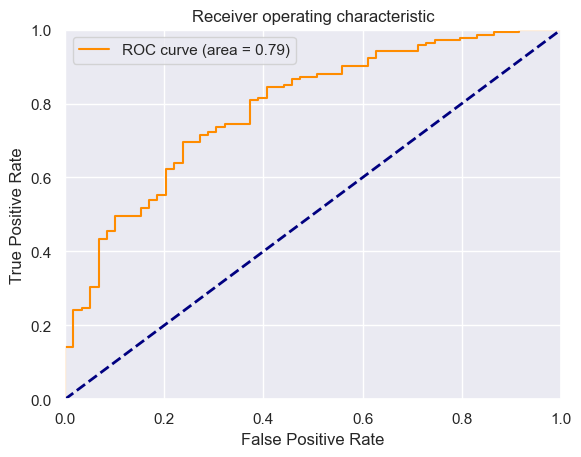

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
params={}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

xgbclf(params2, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

<a id="Balanced Dataset"></a> <br>
# **3. Balanced Dataset** 
- XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)
- XGBoost 2b: Balanced (ROC_AUC:0.80)

In [30]:

from imblearn.over_sampling import SMOTE

# Oversampling
# http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

# Apply SMOTE
sm = SMOTE(sampling_strategy='auto')
X_train_clean_res, y_train_clean_res = sm.fit_resample(X_train_clean, y_train_clean)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{0: 241, 1: 559}
{0: 559, 1: 559}


In [31]:
#Great, before we do anything else, let's split the data into train/test.
X_train_clean_res = pd.DataFrame(X_train_clean_res, columns=X_train_clean.keys())
#y_train_clean_res = pd.DataFrame(y_train_clean_res)

In [32]:
print(np.shape(X_train_clean_res))
print(np.shape(y_train_clean_res))
print(np.shape(X_test_clean)) 
print(np.shape(y_test_clean))

(1118, 61)
(1118, 1)
(200, 61)
(200, 1)


### XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)

[0]	validation_0-auc:0.70802
[1]	validation_0-auc:0.71511
[2]	validation_0-auc:0.72118
[3]	validation_0-auc:0.73627
[4]	validation_0-auc:0.72857
[5]	validation_0-auc:0.72761
[6]	validation_0-auc:0.73044
[7]	validation_0-auc:0.73014
[8]	validation_0-auc:0.74023
[9]	validation_0-auc:0.73753
[10]	validation_0-auc:0.73891
[11]	validation_0-auc:0.73591
[12]	validation_0-auc:0.73158
[13]	validation_0-auc:0.73651
[14]	validation_0-auc:0.73759
[15]	validation_0-auc:0.73663
[16]	validation_0-auc:0.73711
[17]	validation_0-auc:0.73530
[18]	validation_0-auc:0.72869
[19]	validation_0-auc:0.73062
[20]	validation_0-auc:0.72833
[21]	validation_0-auc:0.73134
[22]	validation_0-auc:0.72785
[23]	validation_0-auc:0.72773
[24]	validation_0-auc:0.72713
[25]	validation_0-auc:0.72905
[26]	validation_0-auc:0.73122
[27]	validation_0-auc:0.73170
[28]	validation_0-auc:0.73062
[29]	validation_0-auc:0.72893
[30]	validation_0-auc:0.72833
[31]	validation_0-auc:0.73050
[32]	validation_0-auc:0.73050
[33]	validation_0-au

/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[87]	validation_0-auc:0.74384
[88]	validation_0-auc:0.74312
[89]	validation_0-auc:0.74372
[90]	validation_0-auc:0.74372
[91]	validation_0-auc:0.74360
[92]	validation_0-auc:0.74420
[93]	validation_0-auc:0.74456
[94]	validation_0-auc:0.74396
[95]	validation_0-auc:0.74444
[96]	validation_0-auc:0.74384
[97]	validation_0-auc:0.74528
[98]	validation_0-auc:0.74408
[99]	validation_0-auc:0.74312
[[ 31  28]
 [ 21 120]]
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        59
           1       0.81      0.85      0.83       141

    accuracy                           0.76       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.75      0.76      0.75       200



Model Final Generalization Accuracy: 0.755000


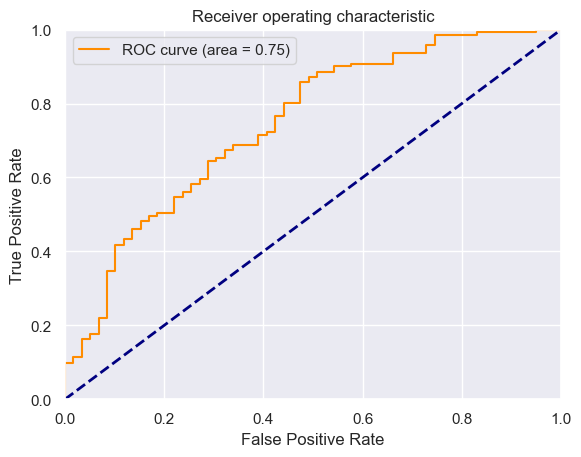

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
#BASE MODEL
params={}
xgbclf(params,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### XGBoost 2b: Balanced (ROC_AUC:0.80)

[0]	validation_0-auc:0.75556
[1]	validation_0-auc:0.75279
[2]	validation_0-auc:0.76031
[3]	validation_0-auc:0.76860
[4]	validation_0-auc:0.77660
[5]	validation_0-auc:0.76163
[6]	validation_0-auc:0.77581
[7]	validation_0-auc:0.77413
[8]	validation_0-auc:0.77004
[9]	validation_0-auc:0.77263
[10]	validation_0-auc:0.77708
[11]	validation_0-auc:0.77624
[12]	validation_0-auc:0.78249
[13]	validation_0-auc:0.77545
[14]	validation_0-auc:0.77918
[15]	validation_0-auc:0.77894
[16]	validation_0-auc:0.78146
[17]	validation_0-auc:0.78122
[18]	validation_0-auc:0.77822
[19]	validation_0-auc:0.78098
[20]	validation_0-auc:0.77894
[21]	validation_0-auc:0.77533
[22]	validation_0-auc:0.77762
[23]	validation_0-auc:0.77521
[24]	validation_0-auc:0.77581
[25]	validation_0-auc:0.77509
[26]	validation_0-auc:0.77654
[27]	validation_0-auc:0.77557
[28]	validation_0-auc:0.77341
[29]	validation_0-auc:0.77618
[30]	validation_0-auc:0.77666
[31]	validation_0-auc:0.77786
[32]	validation_0-auc:0.77762
[33]	validation_0-au

/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[95]	validation_0-auc:0.78615
[96]	validation_0-auc:0.78603
[97]	validation_0-auc:0.78519
[98]	validation_0-auc:0.78495
[99]	validation_0-auc:0.78423
[100]	validation_0-auc:0.78627
[101]	validation_0-auc:0.78675
[102]	validation_0-auc:0.78591
[103]	validation_0-auc:0.78531
[104]	validation_0-auc:0.78519
[105]	validation_0-auc:0.78555
[106]	validation_0-auc:0.78507
[107]	validation_0-auc:0.78519
[108]	validation_0-auc:0.78483
[109]	validation_0-auc:0.78519
[110]	validation_0-auc:0.78507
[111]	validation_0-auc:0.78507
[112]	validation_0-auc:0.78483
[113]	validation_0-auc:0.78483
[114]	validation_0-auc:0.78471
[115]	validation_0-auc:0.78351
[116]	validation_0-auc:0.78399
[117]	validation_0-auc:0.78435
[118]	validation_0-auc:0.78567
[119]	validation_0-auc:0.78543
[120]	validation_0-auc:0.78507
[121]	validation_0-auc:0.78471
[122]	validation_0-auc:0.78435
[123]	validation_0-auc:0.78471
[124]	validation_0-auc:0.78423
[125]	validation_0-auc:0.78471
[126]	validation_0-auc:0.78591
[127]	validat

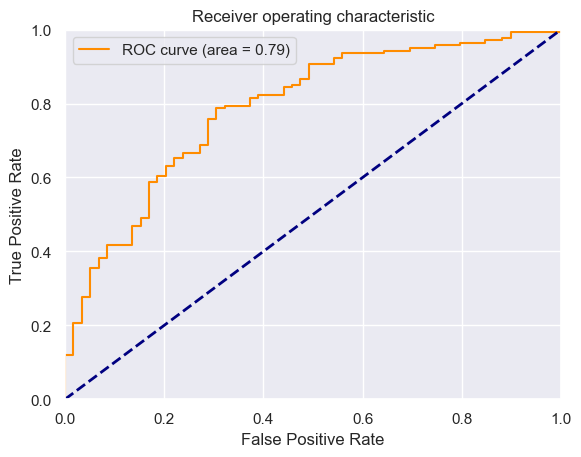

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
params = {}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

#xgbclf(params, X_train, y_train,X_test,y_test)
model = xgbclf(params2,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)
model
#plot_featureImportance(model, X_train_clean_res.keys())

# 4.  Feature Selection
- XGBoost3 (Base Model:ROC_AUC:0.73)
- GridSearchCV (ROC_AUC:0.70)

In [35]:
#model = xgbclf(params1,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

importances = model.feature_importances_
importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(X_train_clean_res.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True, ascending=False)
importance_col = importance_frame.Feature.head(10).values

### XGBoost3 (Base Model:ROC_AUC:0.73)

[0]	validation_0-auc:0.74354
[1]	validation_0-auc:0.73825
[2]	validation_0-auc:0.74396
[3]	validation_0-auc:0.72972
[4]	validation_0-auc:0.73320
[5]	validation_0-auc:0.73741
[6]	validation_0-auc:0.73290
[7]	validation_0-auc:0.73657
[8]	validation_0-auc:0.72791
[9]	validation_0-auc:0.71926
[10]	validation_0-auc:0.72437
[11]	validation_0-auc:0.71030
[12]	validation_0-auc:0.71475
[13]	validation_0-auc:0.71715
[14]	validation_0-auc:0.71595
[15]	validation_0-auc:0.71667
[16]	validation_0-auc:0.71162
[17]	validation_0-auc:0.71138
[18]	validation_0-auc:0.71391
[19]	validation_0-auc:0.71415
[20]	validation_0-auc:0.71102
[21]	validation_0-auc:0.71126
[22]	validation_0-auc:0.71102
[23]	validation_0-auc:0.71114
[24]	validation_0-auc:0.71295
[25]	validation_0-auc:0.71271
[26]	validation_0-auc:0.71198
[27]	validation_0-auc:0.71162
[28]	validation_0-auc:0.70922
[29]	validation_0-auc:0.70922
[30]	validation_0-auc:0.71030
[31]	validation_0-auc:0.70970
[32]	validation_0-auc:0.70862
[33]	validation_0-au

/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[[ 31  28]
 [ 27 114]]
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        59
           1       0.80      0.81      0.81       141

    accuracy                           0.73       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.72      0.72      0.72       200



Model Final Generalization Accuracy: 0.725000


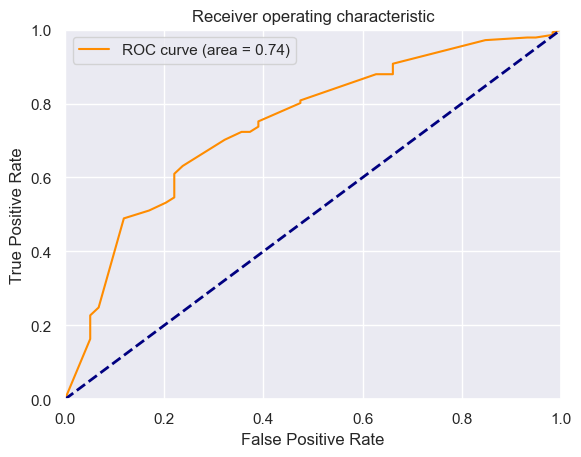

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
params = {}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    #'gamma':0.1,
    #'subsample':0.8,
    #'colsample_bytree':0.3,
    #'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

xgbclf(params,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

### GridSearchCV (ROC_AUC:0.70)

In [38]:
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

print('XGBoost with grid search')
# play with these params
params={
    'learning_rate': [0.01, 0.02],
    'max_depth': [3], # 5 is good but takes too long in kaggle env
    #'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    #'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [50, 100, 200, 300, 400, 500]
    #'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}


xgb_clf = xgb.XGBClassifier()

rs = GridSearchCV(xgb_clf,
                  params,
                  cv=2,
                  scoring="roc_auc",
                  n_jobs=1,
                  verbose=False)
rs.fit(X_train_clean_res[importance_col], y_train_clean_res)
best_est = rs.best_estimator_
print(best_est)
print(rs.best_score_)

# Roc AUC with test data
print(rs.score(X_test_clean[importance_col],y_test_clean))

# Roc AUC with all train data
#y_pred_proba = best_est.predict_proba(X_test_clean[importance_col])[:,1]
#print("Roc AUC: ", roc_auc_score(y_test_clean, y_pred_proba))

#xgbclf(params1,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

XGBoost with grid search
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8642505120327703
0.7338622430580598


<a id="Others"></a> <br>
# 5. Others
- Lighgbm (ROC_AUC:0.73)
- LogisticRegression (ROC_AUC:0.77)
- RandomForestClassifier (ROC_AUC:0.69)
- ExtraTreesClassifier (ROC_AUC:0.74)
- DecisionTreeClassifier (ROC_AUC:0.64)
- GradientBoostingClassifier (ROC_AUC:0.76)
- AdaBoostClassifier (ROC_AUC:0.72)

### Lighgbm (ROC_AUC:0.73)

[LightGBM] [Info] Number of positive: 559, number of negative: 559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBMClassifier() 



/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


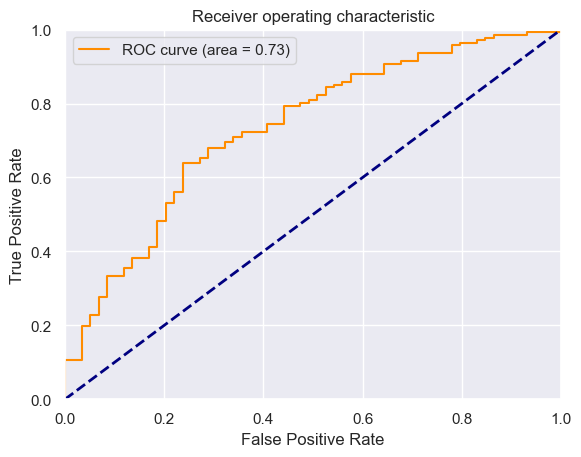

In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import lightgbm as lgb

# fit, train and cross validate Decision Tree with training and test data 
def lgbclf(X_train, y_train,X_test, y_test):

    model = lgb.LGBMClassifier().fit(X_train, y_train)
    print(model,'\n')

    # Predict target variables y for test data
    y_pred = model.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train,y_test,y_pred)
    #get_eval2(model, X_train, y_train,X_test, y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Logistic Regression
#lgbclf(X_train, y_train,X_test,y_test)
lgbclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### LogisticRegression (ROC_AUC:0.77)

LogisticRegression
LogisticRegression() 



/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


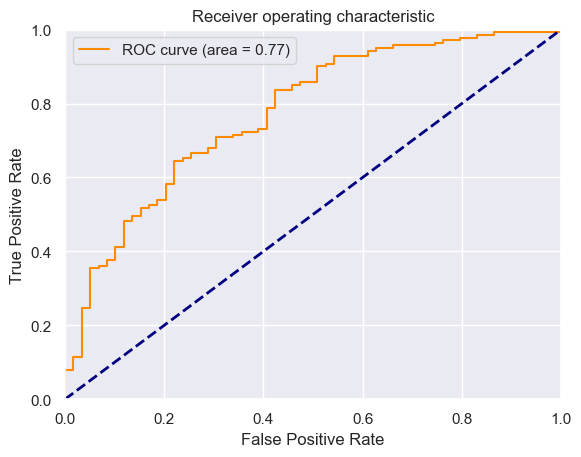

In [40]:
from sklearn.linear_model import LogisticRegression

# fit, train and cross validate Decision Tree with training and test data 
def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    model = LogisticRegression().fit(X_train, y_train)
    print(model,'\n')

    # Predict target variables y for test data
    y_pred = model.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train,y_test,y_pred)
    #get_eval2(model, X_train, y_train,X_test, y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Logistic Regression
#logregclf(X_train, y_train,X_test,y_test)
logregclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### RandomForestClassifier (ROC_AUC:0.69)

RandomForestClassifier
RandomForestClassifier() 



/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


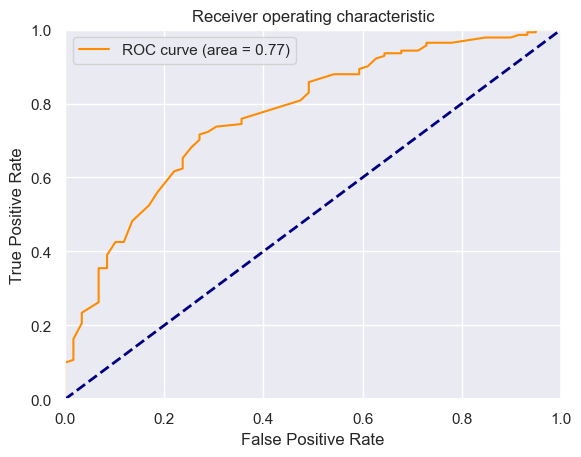

In [41]:
from sklearn.ensemble import RandomForestClassifier 

# fit, train and cross validate Decision Tree with training and test data 
def randomforestclf(X_train, y_train,X_test, y_test):
    print("RandomForestClassifier")
    randomforest = RandomForestClassifier().fit(X_train, y_train)
    print(randomforest,'\n')
    
    # Predict target variables y for test data
    y_pred = randomforest.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(randomforest, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Random Forest
# Choose clean data, as tree is robust
randomforestclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### ExtraTreesClassifier (ROC_AUC:0.74)

ExtraTreesClassifier
ExtraTreesClassifier() 



/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


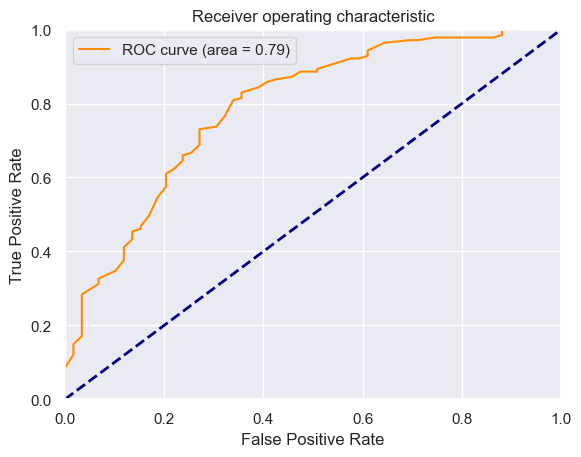

In [42]:
from sklearn.ensemble import ExtraTreesClassifier

# fit, train and cross validate Decision Tree with training and test data 
def extratreesclf(X_train, y_train,X_test, y_test):
    print("ExtraTreesClassifier")
    extratrees = ExtraTreesClassifier().fit(X_train, y_train)
    print(extratrees,'\n')
    
    # Predict target variables y for test data
    y_pred = extratrees.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(extratrees, X_train, y_train,y_test,y_pred)
    
    get_roc (y_test,y_pred)
    return
 
# Extra Trees
# Choose clean data, as tree is robust
extratreesclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### DecisionTreeClassifier (ROC_AUC:0.64)

DecisionTreeClassifier
DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=10) 



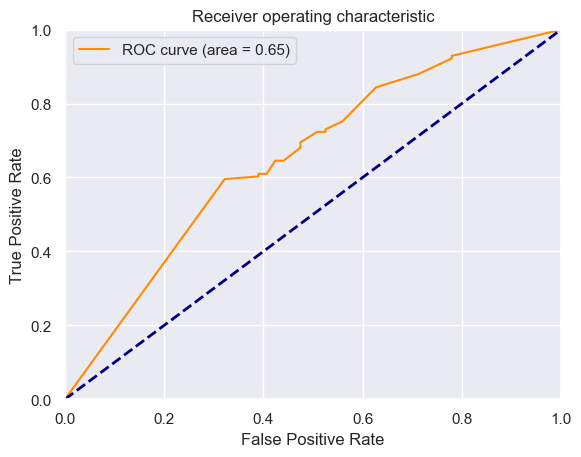

In [43]:
from sklearn.tree import DecisionTreeClassifier 
# fit, train and cross validate Decision Tree with training and test data 
def dectreeclf(X_train, y_train,X_test, y_test):
    print("DecisionTreeClassifier")
    dec_tree = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=5).fit(X_train, y_train)
    print(dec_tree,'\n')
    
    # Predict target variables y for test data
    y_pred = dec_tree.predict_proba(X_test)[:,1]

    
    # Get Cross Validation and Confusion matrix
    #get_eval(dec_tree, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Decisiontree
dectreeclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### GradientBoostingClassifier (ROC_AUC:0.76)

GradientBoostingClassifier
GradientBoostingClassifier() 



/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


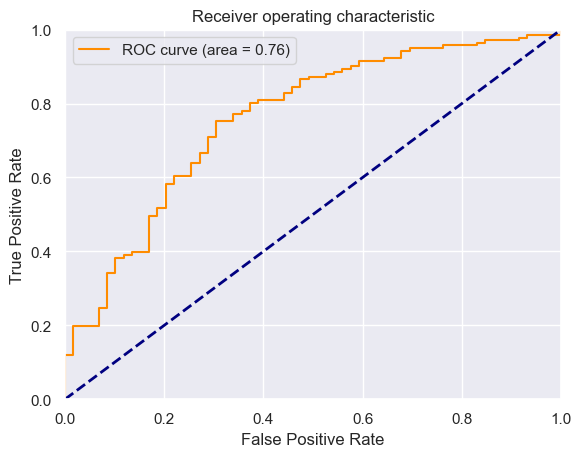

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

# fit, train and cross validate GradientBoostingClassifier with training and test data 
def gradientboostingclf(X_train, y_train, X_test, y_test):  
    print("GradientBoostingClassifier")
    gbclf = GradientBoostingClassifier().fit(X_train, y_train)
    print(gbclf,'\n')
    
    # Predict target variables y for test data
    y_pred = gbclf.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(gbclf, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return
  
# GradientBoostingClassifier
# Choose clean data, as tree is robust
gradientboostingclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### AdaBoostClassifier (ROC_AUC:0.75)

AdaBoostClassifier
AdaBoostClassifier() 



/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


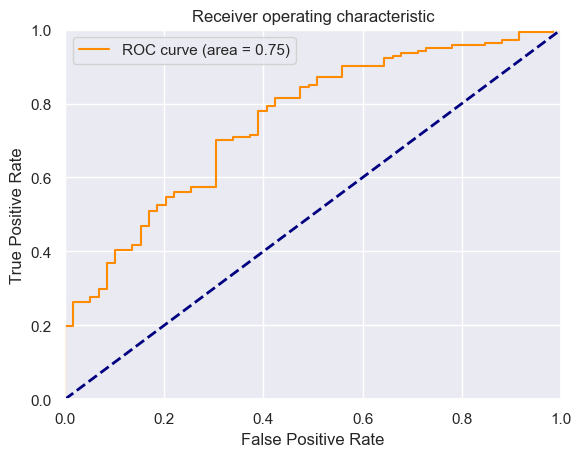

In [45]:
from sklearn.ensemble import AdaBoostClassifier

# fit, train and cross validate GradientBoostingClassifier with training and test data 
def adaboostclf(X_train, y_train, X_test, y_test):  
    print("AdaBoostClassifier")
    abclf = AdaBoostClassifier().fit(X_train, y_train)
    print(abclf,'\n')
    
    # Predict target variables y for test data
    y_pred = abclf.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(abclf, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# AdaBoostClassifier
# Choose clean data, as tree is robust
adaboostclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)